# Pneumonia Image Classification - Machine Learning

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ruicalovri","key":"010fb6747de873bf727898964a639ad4"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

## Importing the database

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:01<00:00, 39.7MB/s]
100% 2.29G/2.29G [01:01<00:00, 40.2MB/s]


In [ ]:
!unzip "/content/drive/MyDrive/chest_xray.zip"


### Required libraries

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from sklearn.metrics import classification_report
import numpy

### Data Preprocessing

1. Preprocessing the training data set

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

img_width, img_height = 64, 64
training_set = train_datagen.flow_from_directory('/content/chest_xray/train',
                                                 target_size = (img_width, img_height),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 3397 images belonging to 2 classes.


2. Examining the balance between classes

In [ ]:
from collections import Counter
cases_count = Counter(training_set.classes)
print(cases_count.items())

dict_items([(0, 1137), (1, 2260)])


3. Data balancing

In [ ]:
total = cases_count[0] + cases_count[1]
weight_for_0 = (1 / cases_count[0]) * (total / 2.0)
weight_for_1 = (1 / cases_count[1]) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

{0: 1.4938434476693052, 1: 0.7515486725663717}


4. Preprocessing the validation set

In [ ]:
val_datagen = ImageDataGenerator(rescale = 1./255)
val_set = val_datagen.flow_from_directory('/content/chest_xray/val',
                                            target_size = (img_width, img_height),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 1835 images belonging to 2 classes.


5. Test set preprocessing

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/content/chest_xray/test',
                                            target_size = (img_width, img_height),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle=False)

Found 624 images belonging to 2 classes.


## Creation of a convolutional neural network (CNN)

Izrada modela


In [ ]:
cnn = tf.keras.Sequential()

First step - Convolution

In [ ]:
cnn.add(tf.keras.layers.Conv2D(filters=32,
                               kernel_size=3,
                               activation='relu',
                               input_shape=[64, 64, 3]))

Second step - Compression

In [ ]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

Third step - Adding a second convolutional layer

In [ ]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

Fourth step - Alignment

In [ ]:
cnn.add(tf.keras.layers.Flatten())

Fifth step - Full connection

In [ ]:
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

Sixth step - Outer layer

In [ ]:
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

Model Architecture

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               8

## Training of a convolutional neural network (CNN)

1. Compiling

In [ ]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

2. Start training

In [ ]:
model_fit = cnn.fit(x = training_set, validation_data = val_set, epochs = 6, class_weight=class_weight)

3. View model history keys

In [ ]:
model_fit.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

4. Display of precision when tattooing the model

In [ ]:
import matplotlib.pyplot as plt

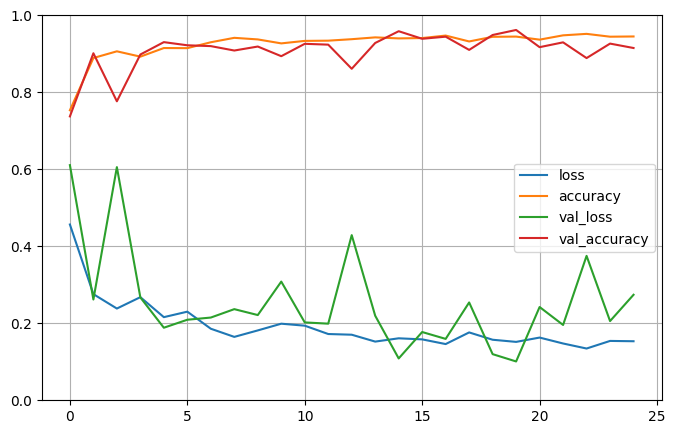

In [ ]:
import pandas as pd
pd.DataFrame(model_fit.history).plot(figsize=(8,5))
plt.grid(True)
plt.ylim(0,1)
plt.show()

# Model evaluation

In [ ]:
model_evaluation = cnn.evaluate(test_set)

20/20 [==============================] - 6s 269ms/step - loss: 0.2402 - accuracy: 0.9071


1. Accuracy of the model

In [ ]:
print(f"Model Accuracy: {model_evaluation[1]*100: 0.2f}%")

Model Accuracy:  90.71%


## Confusion matrix and detailed report

1. Class prediction on the test set

In [ ]:
preds = np.round(cnn.predict(test_set),0)

20/20 [==============================] - 5s 239ms/step


In [ ]:
gt_class = test_set.classes
gt_labels = list(test_set.class_indices.keys())

2. Confusion matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
cm = confusion_matrix(gt_class, preds)
print(cm)
print('The cnn model has an accuracy score of {:.2f} and recall score of {:.2f} for {:s}'.format((accuracy_score(gt_class, preds) *100),
                                                                                                 (recall_score(gt_class, preds) *100),gt_labels[1]))

[[203  31]
 [ 27 363]]
The cnn model has an accuracy score of 90.71 and recall score of 93.08 for PNEUMONIA


3. Detailed report

In [ ]:
report = classification_report(gt_class, preds, target_names=gt_labels)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.88      0.87      0.88       234
   PNEUMONIA       0.92      0.93      0.93       390

    accuracy                           0.91       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



# Testing on your own image

1. Picture of diseased lungs

In [ ]:
!curl -o rendgen.jpeg https://zdravlje.eu/wp-content/uploads/2009/11/pneumonija.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28620  100 28620    0     0  37024      0 --:--:-- --:--:-- --:--:-- 36976


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
slika = plt.imread("rendgen.jpeg")

In [ ]:
slika.shape

(558, 711, 3)

In [ ]:
from skimage.transform import resize
slika_novo = resize(slika, (64,64))

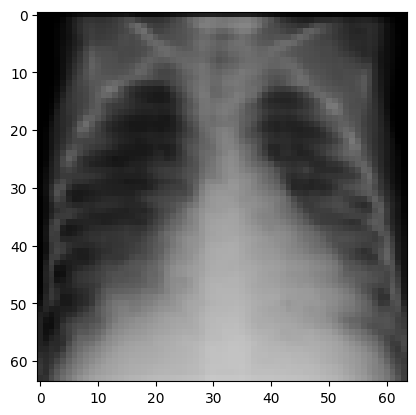

In [ ]:
img = plt.imshow(slika_novo)

In [ ]:
import numpy as np
vjerojatnosti = cnn.predict(np.array([slika_novo]))
vjerojatnosti

1/1 [==============================] - 0s 136ms/step


array([[0.6581776]], dtype=float32)

In [ ]:
broj_u_klasu =['Pneumonia', 'Normal']
index = np.argsort(vjerojatnosti[0,:])
print ("Najvjerojatnije pripada klasi:", broj_u_klasu[index[0]], vjerojatnosti[0])


Najvjerojatnije pripada klasi: Pneumonia [0.6581776]


It most likely belongs to the class: Pneumonia [0.6581776]

2. Prikaz slike zdravih pluća

In [ ]:
!curl -o zdrava.jpg https://irp-cdn.multiscreensite.com/27ee385d/dms3rep/multi/rtgpc.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 95256  100 95256    0     0   236k      0 --:--:-- --:--:-- --:--:--  236k


In [ ]:
slika2 = plt.imread("zdrava.jpg")

In [ ]:
from skimage.transform import resize
slika2_novo = resize(slika2, (64,64))

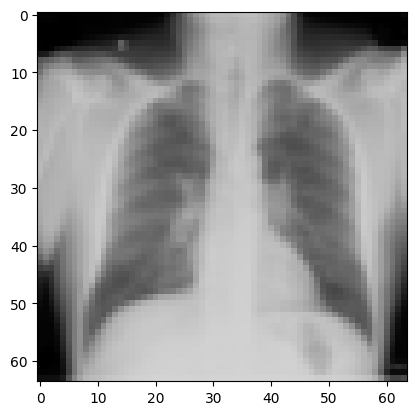

In [ ]:
img = plt.imshow(slika2_novo)

In [ ]:
vjerojatnosti = cnn.predict(np.array([slika2_novo]))
vjerojatnosti

1/1 [==============================] - 0s 19ms/step


array([[0.05881465]], dtype=float32)

In [ ]:
broj_u_klasu =['Pneumonia', 'Normal']
index = np.argsort(vjerojatnosti[0,:])
print ("Vjerojatnost da ova osoba ima upalu pluca je:", vjerojatnosti[0])

Vjerojatnost da ova osoba ima upalu pluca je: [0.05881465]


The probability that this person has pneumonia is: [0.05881465]

# Testing more models

## Model 3 - ResNet

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50


from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Create the ResNet50 model
base_model = ResNet50(include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,112,513
Trainable params: 524,801
Non-trainable params: 23,587,712
____________________________________

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=["acc"]
    )

#Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "model3.h5", save_best_only=True, #the best model observed during training is saved for later use
    verbose=1
    )

#This callback will stop the training when there is no improvement in validation accuracy (val_acc) across epochs
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

In [ ]:
#Training

history = model.fit(
    x = training_set, validation_data = val_set,  #validation dataset
    epochs=5, #the number of epochs to be performed
    verbose=1,
    #steps_per_epoch=step_size_train,
    #validation_steps=step_size_test,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/5
107/107 [==============================] - ETA: 0s - loss: 0.5422 - acc: 0.6653
Epoch 1: val_loss improved from inf to 0.27125, saving model to model3.h5
107/107 [==============================] - 74s 651ms/step - loss: 0.5422 - acc: 0.6653 - val_loss: 0.2712 - val_acc: 0.8845
Epoch 2/5
107/107 [==============================] - ETA: 0s - loss: 0.4421 - acc: 0.6653
Epoch 2: val_loss did not improve from 0.27125
107/107 [==============================] - 75s 701ms/step - loss: 0.4421 - acc: 0.6653 - val_loss: 0.3613 - val_acc: 0.8845
Epoch 3/5
107/107 [==============================] - ETA: 0s - loss: 0.4088 - acc: 0.6653
Epoch 3: val_loss did not improve from 0.27125
107/107 [==============================] - 64s 601ms/step - loss: 0.4088 - acc: 0.6653 - val_loss: 0.3538 - val_acc: 0.8845
Epoch 4/5
107/107 [==============================] - ETA: 0s - loss: 0.3963 - acc: 0.6653
Epoch 4: val_loss did not improve from 0.27125
107/107 [==============================] - 64s 597ms/

In [ ]:
#Saving the trained model so it can be reused later

model.save('/content/gdrive/My Drive/Bruno/resnet.h5')

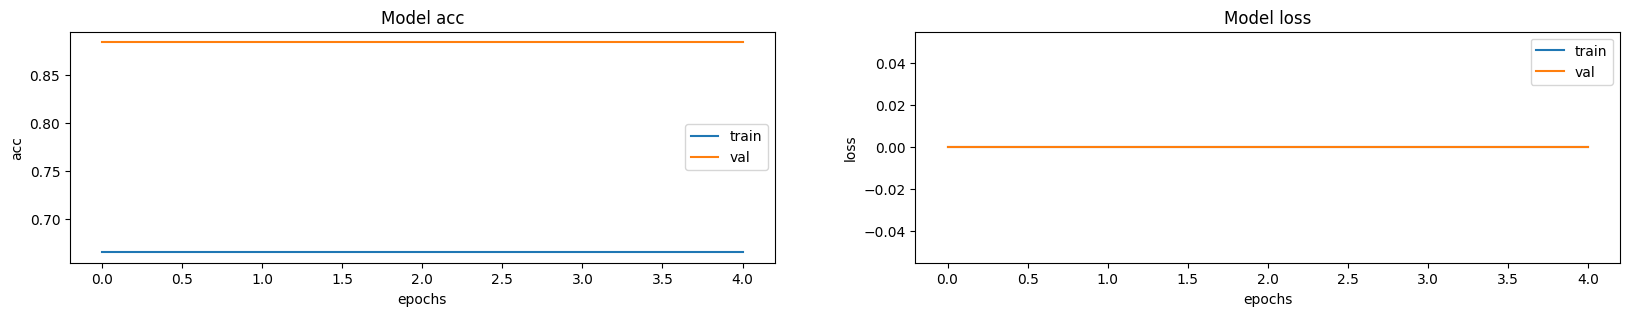

In [ ]:
#Display the graphs corresponding to the training and validation stages of the model

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

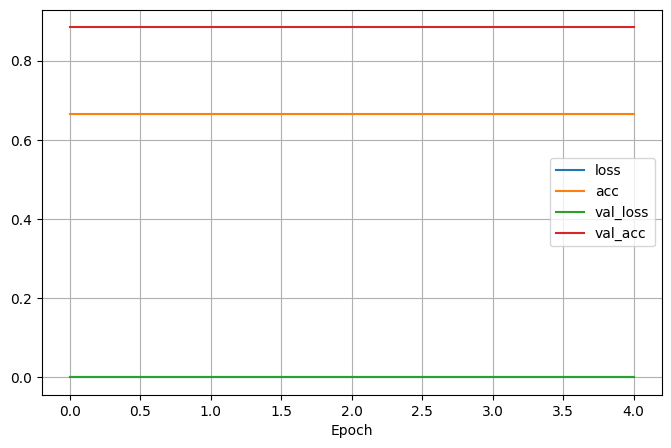

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.xlabel('Epoch')
plt.show()

## Model 5 - ResNet, pretrained on ImageNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 model pretrained on ImageNet without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model layers
base_model.trainable = False

# Create the classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
prediction = Dense(1, activation='softmax')(x)

# Combine the base model and the classification head
model = Model(inputs=base_model.input, outputs=prediction)

# Print the model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=["acc"]
    )

#Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "model4_bruno.h5", save_best_only=True, #the best model observed during training is saved for later use
    verbose=1
    )

#This callback will stop the training when there is no improvement in validation accuracy (val_acc) across epochs
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

In [ ]:
#Training

history = model.fit(
x = training_set, validation_data = val_set,  #validation dataset
    epochs=5, #the number of epochs to be performed
    verbose=1,
    #steps_per_epoch=step_size_train,
    #validation_steps=step_size_test,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

In [ ]:
#Saving the trained model so it can be reused later

model.save('/content/gdrive/My Drive/Foodclassification/dataset/models_v3/model5_40_32_imagenet.h5')

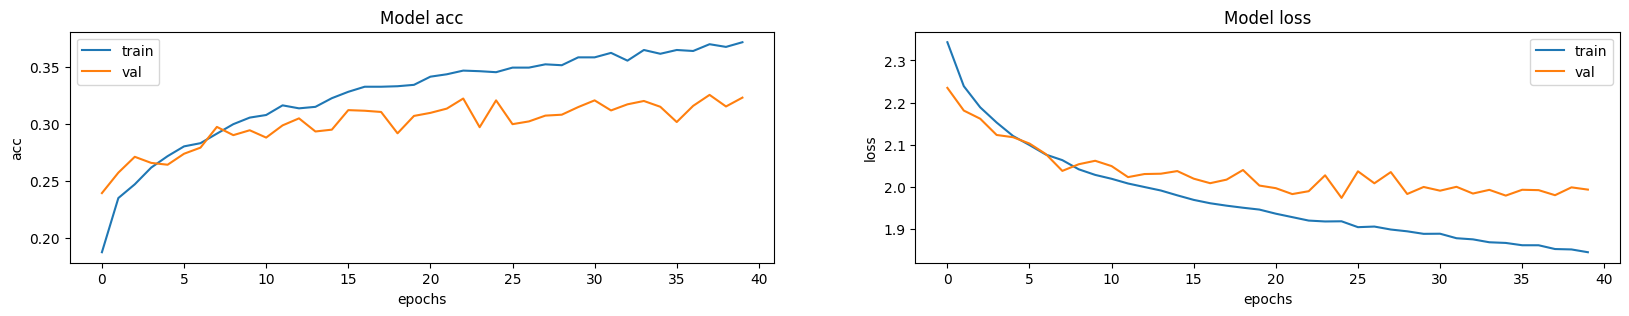

In [ ]:
#Display the graphs corresponding to the training and validation stages of the model

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

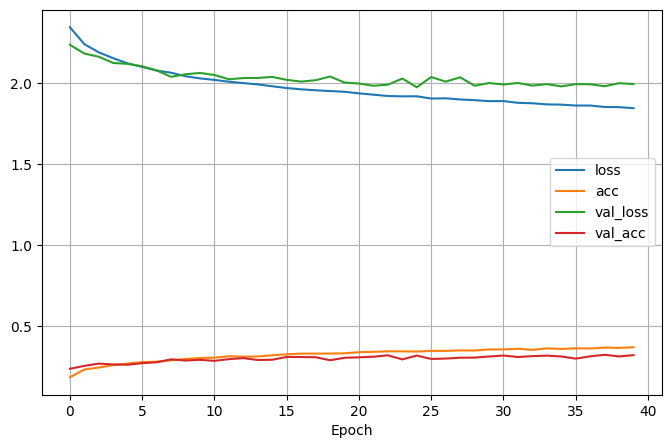

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.xlabel('Epoch')
plt.show()

## DenseNet121

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the pre-trained DenseNet121 model without the top (fully connected) layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the base model's layers to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

29084464/29084464 [==============================] - 0s 0us/step


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_6[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][0]']             
                                                                                            

In [ ]:
model_fit = model.fit(x = training_set, validation_data = val_set, epochs = 15)

Epoch 1/15
107/107 [==============================] - 65s 599ms/step - loss: 0.2106 - accuracy: 0.9264 - val_loss: 0.3450 - val_accuracy: 0.8747
Epoch 2/15
107/107 [==============================] - 64s 598ms/step - loss: 0.1824 - accuracy: 0.9311 - val_loss: 0.1850 - val_accuracy: 0.9253
Epoch 3/15
107/107 [==============================] - 68s 640ms/step - loss: 0.1946 - accuracy: 0.9226 - val_loss: 0.2177 - val_accuracy: 0.9090
Epoch 4/15
107/107 [==============================] - 70s 656ms/step - loss: 0.1712 - accuracy: 0.9329 - val_loss: 0.2456 - val_accuracy: 0.8992
Epoch 5/15
107/107 [==============================] - 84s 784ms/step - loss: 0.1564 - accuracy: 0.9382 - val_loss: 0.2218 - val_accuracy: 0.9095
Epoch 6/15
107/107 [==============================] - 75s 705ms/step - loss: 0.1725 - accuracy: 0.9332 - val_loss: 0.3117 - val_accuracy: 0.8817
Epoch 7/15
107/107 [==============================] - 69s 642ms/step - loss: 0.1781 - accuracy: 0.9320 - val_loss: 0.3084 - val_ac

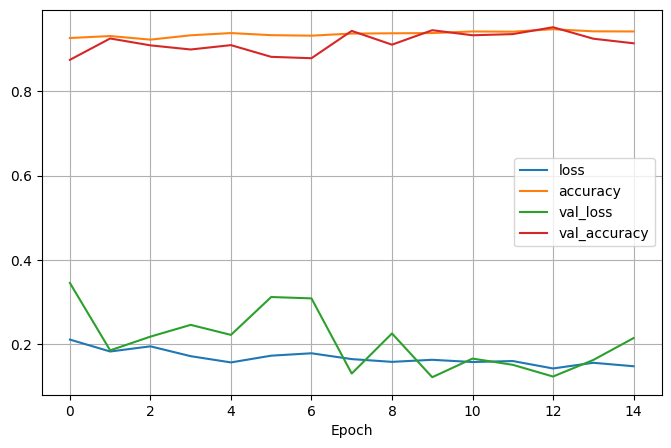

In [ ]:
import pandas as pd
pd.DataFrame(model_fit.history).plot(figsize=(8,5))
plt.grid(True)
plt.xlabel('Epoch')
plt.show()

### Evaluacija modela

In [ ]:
model_evaluation = model.evaluate(test_set)

20/20 [==============================] - 7s 300ms/step - loss: 0.2912 - accuracy: 0.8926


1. Accuracy of the model

In [ ]:
print(f"Model Accuracy: {model_evaluation[1]*100: 0.2f}%")

Model Accuracy:  89.26%


### Confusion matrix and detailed report

1. Prediction of classes on the test set

In [ ]:
preds = np.round(model.predict(test_set),0)

20/20 [==============================] - 11s 317ms/step


In [ ]:
gt_class = test_set.classes
gt_labels = list(test_set.class_indices.keys())

2. Confusion matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
cm = confusion_matrix(gt_class, preds)
print(cm)
print('The cnn model has an accuracy score of {:.2f} and recall score of {:.2f} for {:s}'.format((accuracy_score(gt_class, preds) *100),
                                                                                                 (recall_score(gt_class, preds) *100),gt_labels[1]))

[[186  48]
 [ 19 371]]
The cnn model has an accuracy score of 89.26 and recall score of 95.13 for PNEUMONIA


3. Detailed report

In [ ]:
report = classification_report(gt_class, preds, target_names=gt_labels)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.91      0.79      0.85       234
   PNEUMONIA       0.89      0.95      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



### Testing on your own image

1. Picture of diseased lungs

In [ ]:
!curl -o rendgen.jpeg https://zdravlje.eu/wp-content/uploads/2009/11/pneumonija.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28620  100 28620    0     0  37559      0 --:--:-- --:--:-- --:--:-- 37559


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
slika = plt.imread("rendgen.jpeg")

In [ ]:
slika.shape

(558, 711, 3)

In [ ]:
from skimage.transform import resize
slika_novo = resize(slika, (64,64))

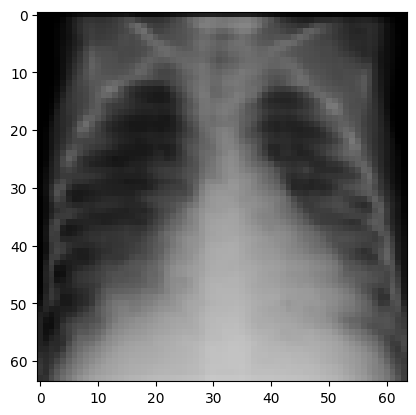

In [ ]:
img = plt.imshow(slika_novo)

In [ ]:
import numpy as np
vjerojatnosti = model.predict(np.array([slika_novo]))
vjerojatnosti

1/1 [==============================] - 0s 30ms/step


array([[0.6581776]], dtype=float32)

In [ ]:
broj_u_klasu =['Pneumonia', 'Normal']
index = np.argsort(vjerojatnosti[0,:])
print ("Najvjerojatnije pripada klasi:", broj_u_klasu[index[0]], vjerojatnosti[0])


Najvjerojatnije pripada klasi: Pneumonia [0.6581776]


It most likely belongs to the class: Pneumonia [0.6581776]

2. Picture of healthy lungs

In [ ]:
!curl -o zdrava.jpg https://irp-cdn.multiscreensite.com/27ee385d/dms3rep/multi/rtgpc.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 95256  100 95256    0     0   959k      0 --:--:-- --:--:-- --:--:--  959k


In [ ]:
slika2 = plt.imread("zdrava.jpg")

In [ ]:
from skimage.transform import resize
slika2_novo = resize(slika2, (64,64))

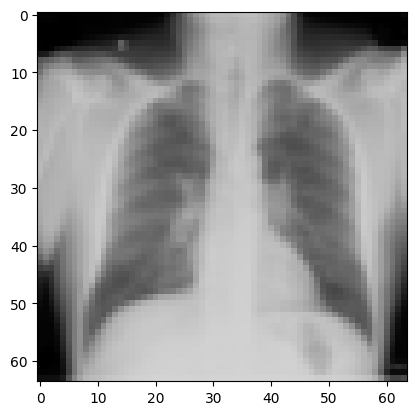

In [ ]:
img = plt.imshow(slika2_novo)

In [ ]:
vjerojatnosti = cnn.predict(np.array([slika2_novo]))
vjerojatnosti

1/1 [==============================] - 0s 21ms/step


array([[0.05881465]], dtype=float32)

In [ ]:
broj_u_klasu =['Pneumonia', 'Normal']
index = np.argsort(vjerojatnosti[0,:])
print ("Vjerojatnost da ova osoba ima upalu pluca je:", vjerojatnosti[0])

Vjerojatnost da ova osoba ima upalu pluca je: [0.05881465]


The probability that this person has pneumonia is: [0.05881465]

## MobileNet

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the pre-trained MobileNetV2 model without the top (fully connected) layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the base model's layers to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential()

# Add the base model as a layer
model.add(base_model)

# Add custom classification layers on top of the base model
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

9406464/9406464 [==============================] - 0s 0us/step


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 256)               327936    
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 2,586,177
Trainable params: 328,193
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model_fit = model.fit(x = training_set, validation_data = val_set, epochs = 15)

Epoch 1/15
107/107 [==============================] - 80s 709ms/step - loss: 0.2771 - accuracy: 0.8934 - val_loss: 0.1697 - val_accuracy: 0.9226
Epoch 2/15
107/107 [==============================] - 73s 687ms/step - loss: 0.2252 - accuracy: 0.9135 - val_loss: 0.3373 - val_accuracy: 0.8534
Epoch 3/15
107/107 [==============================] - 68s 642ms/step - loss: 0.2014 - accuracy: 0.9238 - val_loss: 0.2885 - val_accuracy: 0.8834
Epoch 4/15
107/107 [==============================] - 62s 582ms/step - loss: 0.1935 - accuracy: 0.9223 - val_loss: 0.2433 - val_accuracy: 0.8992
Epoch 5/15
107/107 [==============================] - 65s 607ms/step - loss: 0.1907 - accuracy: 0.9285 - val_loss: 0.2510 - val_accuracy: 0.8992
Epoch 6/15
107/107 [==============================] - 68s 638ms/step - loss: 0.1851 - accuracy: 0.9314 - val_loss: 0.2287 - val_accuracy: 0.8997
Epoch 7/15
107/107 [==============================] - 67s 631ms/step - loss: 0.1718 - accuracy: 0.9352 - val_loss: 0.2526 - val_ac

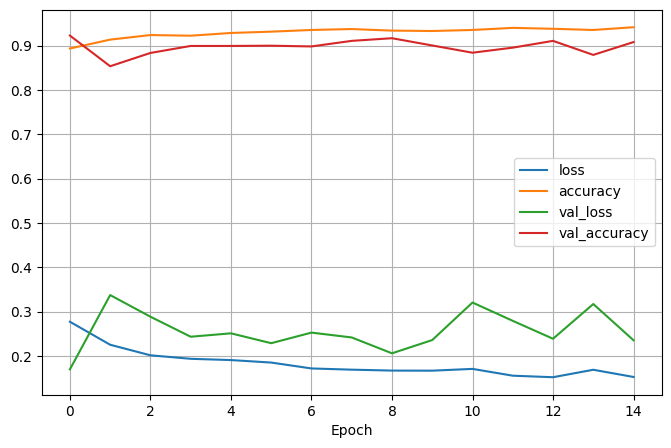

In [ ]:
import pandas as pd
pd.DataFrame(model_fit.history).plot(figsize=(8,5))
plt.grid(True)
plt.xlabel('Epoch')
plt.show()

### Model evaluation

In [ ]:
model_evaluation = model.evaluate(test_set)

20/20 [==============================] - 7s 316ms/step - loss: 0.4625 - accuracy: 0.8462


1. Accuracy of the model

In [ ]:
print(f"Model Accuracy: {model_evaluation[1]*100: 0.2f}%")

Model Accuracy:  84.62%


### Confusion matrix and detailed report

1. Class prediction on the test set

In [ ]:
preds = np.round(model.predict(test_set),0)

20/20 [==============================] - 39s 2s/step


In [ ]:
gt_class = test_set.classes
gt_labels = list(test_set.class_indices.keys())

2. Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
cm = confusion_matrix(gt_class, preds)
print(cm)
print('The cnn model has an accuracy score of {:.2f} and recall score of {:.2f} for {:s}'.format((accuracy_score(gt_class, preds) *100),
                                                                                                 (recall_score(gt_class, preds) *100),gt_labels[1]))

[[163  71]
 [ 25 365]]
The cnn model has an accuracy score of 84.62 and recall score of 93.59 for PNEUMONIA


3. Detailed report

In [ ]:
report = classification_report(gt_class, preds, target_names=gt_labels)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.87      0.70      0.77       234
   PNEUMONIA       0.84      0.94      0.88       390

    accuracy                           0.85       624
   macro avg       0.85      0.82      0.83       624
weighted avg       0.85      0.85      0.84       624



### Testiranje na vlastitoj slici

1. Picture of diseased lungs

In [ ]:
!curl -o rendgen.jpeg https://zdravlje.eu/wp-content/uploads/2009/11/pneumonija.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28620  100 28620    0     0  38007      0 --:--:-- --:--:-- --:--:-- 37957


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
slika = plt.imread("rendgen.jpeg")

In [ ]:
slika.shape

(558, 711, 3)

In [ ]:
from skimage.transform import resize
slika_novo = resize(slika, (64,64))

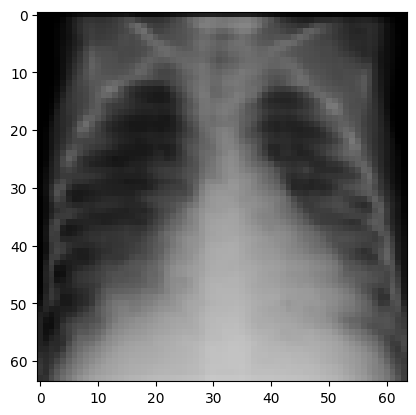

In [ ]:
img = plt.imshow(slika_novo)

In [ ]:
import numpy as np
vjerojatnosti = model.predict(np.array([slika_novo]))
vjerojatnosti

1/1 [==============================] - 1s 1s/step


array([[0.9906155]], dtype=float32)

In [ ]:
broj_u_klasu =['Pneumonia', 'Normal']
index = np.argsort(vjerojatnosti[0,:])
print ("Najvjerojatnije pripada klasi:", broj_u_klasu[index[0]], vjerojatnosti[0])


Najvjerojatnije pripada klasi: Pneumonia [0.9906155]


It most likely belongs to the class: Pneumonia [0.9906155]

2. Picture of healthy lungs

In [ ]:
!curl -o zdrava.jpg https://irp-cdn.multiscreensite.com/27ee385d/dms3rep/multi/rtgpc.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 95256  100 95256    0     0  1000k      0 --:--:-- --:--:-- --:--:-- 1000k


In [ ]:
slika2 = plt.imread("zdrava.jpg")

In [ ]:
from skimage.transform import resize
slika2_novo = resize(slika2, (64,64))

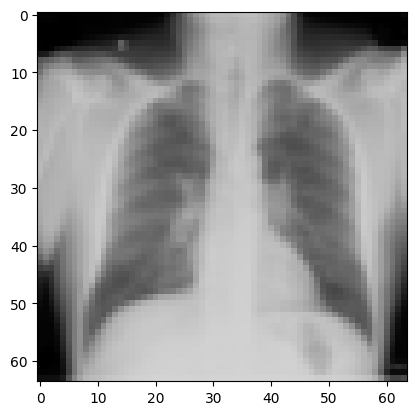

In [ ]:
img = plt.imshow(slika2_novo)

In [ ]:
vjerojatnosti = model.predict(np.array([slika2_novo]))
vjerojatnosti

In [ ]:
broj_u_klasu =['Pneumonia', 'Normal']
index = np.argsort(vjerojatnosti[0,:])
print ("Vjerojatnost da ova osoba ima upalu pluca je:", vjerojatnosti[0])